# Setup

### Path to training data on drive

In [ ]:
path_folder = "../splits_final_deblurred"
class_names = ["background", "rigid_plastic", "cardboard", "metal", "soft_plastic"]
class_colors = [[0,0,0], [0,0,255], [0,255,0], [255,0,0] ,[125,0,125]]
num_classes = len(class_names)
input_dim = (224, 224)

### Imports

In [ ]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Activation, concatenate, BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Input
import matplotlib.pyplot as plt
import numpy as np
from keras.activations import softmax
from PIL import Image
from tensorflow.keras.utils import Sequence
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import keras
import os
import random
import json
import cv2
from sklearn.metrics import confusion_matrix

### Helper Functions

In [ ]:

def Make_Overlapping_Plot2(image, label=None, pred=None):
    '''
    Makes one/two/three plots, first is the image, the others are segmentation/predicitons combined with image where background is unchanged, all other classes
    have a color.
    \n RED: Rigid Plastic
    \n GREEN: Cardboard
    \n BLUE: Metal
    \n PURPLE: Soft plastic.
    '''
    _, ax1 = plt.subplots()
    ax1.set_title("Image")
    ax1.imshow(image)

    if label is not None:
      red = np.where(label[:,:,1] == 1)
      green = np.where(label[:,:,2] == 1)
      blue = np.where(label[:,:,3] == 1)
      purple = np.where(label[:,:,4] == 1)
      image2 = np.copy(image)
      image2[red] = class_colors[1]
      image2[green] = class_colors[2]
      image2[blue] = class_colors[3]
      image2[purple] = class_colors[4]
      _, ax2 =plt.subplots()
      ax2.set_title("Overlapping Labels")
      ax2.imshow(image2)

    if pred is not None:
      image3 = np.copy(image)
      red = np.where(pred[:,:,1] >= 0.5)
      green = np.where(pred[:,:,2] >= 0.5)
      blue = np.where(pred[:,:,3] >= 0.5)
      purple = np.where(pred[:,:,4] >= 0.5)
      image3[red] = class_colors[1]
      image3[green] = class_colors[2]
      image3[blue] = class_colors[3]
      image3[purple] = class_colors[4]
      _, ax3 =plt.subplots()
      ax3.set_title("predictions")
      ax3.imshow(image3)

    plt.show()
    return 0

def create_y_labels(loaded_labels, y_labels):
  if loaded_labels.ndim == 3:
    for i in range(0,y_labels.shape[0]):
      background = np.where(loaded_labels[i,:,:] == 0)
      red = np.where(loaded_labels[i,:,:] == 1)
      green = np.where(loaded_labels[i,:,:] == 2)
      blue = np.where(loaded_labels[i,:,:] == 3)
      purple = np.where(loaded_labels[i,:,:] == 4)
      y_labels[i,:,:,0][background] = 1 #Background
      y_labels[i,:,:,1][red] = 1        #Rigid Plast
      y_labels[i,:,:,2][green] = 1      #Cardboard
      y_labels[i,:,:,3][blue] = 1       #Metal
      y_labels[i,:,:,4][purple] = 1     #SoftPlast
  else:
    for i in range(0,y_labels.shape[0]):
      background = np.where(loaded_labels[i,:,:,0] == 0)
      red = np.where(loaded_labels[i,:,:,0] == 1)
      green = np.where(loaded_labels[i,:,:,0] == 2)
      blue = np.where(loaded_labels[i,:,:,0] == 3)
      purple = np.where(loaded_labels[i,:,:,0] == 4)
      y_labels[i,:,:,0][background] = 1 #Background
      y_labels[i,:,:,1][red] = 1        #Rigid Plast
      y_labels[i,:,:,2][green] = 1      #Cardboard
      y_labels[i,:,:,3][blue] = 1       #Metal
      y_labels[i,:,:,4][purple] = 1     #SoftPlast
  return y_labels

# Model

Loss function

In [ ]:
def dice_coef(y_true, y_pred):
  y_true = tf.reshape(tf.cast(y_true, tf.float64), [-1])
  y_pred = tf.reshape(tf.cast(y_pred, tf.float64), [-1])
  intersection = K.sum(y_true * y_pred)
  union = K.sum(y_true) + K.sum(y_pred)
  epsilon = 1e-4
  return (2*intersection + epsilon)/(union+epsilon)

def dice_loss_function(y_true, y_pred):
  coef = 0.
  for i in range(5):
    coef += dice_coef(y_true[:,:,:,i], y_pred[:,:,:,i])
  return 1-coef/5.

Similar to the model described in https://qims.amegroups.org/article/view/91409/pdf , page 3143, figure 3(b)

In [ ]:
# See last layer of network
def softMaxAxis3(x):
    return softmax(x,axis=3)

def my_conv(x,filters,kernel_size=3,padding='same',kernel_initializer='he_normal'):
  x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer, strides=1)(x)
  #x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

def apply_tensor_to_layers(x, layers):
  for l in layers:
    x = l(x)
  return x

vgg16 = keras.applications.VGG16(weights="imagenet",input_shape=(*input_dim, 3), include_top=False)
inputs = keras.Input(shape=(*input_dim, 3))
x = preprocess_input(inputs)  #shifts from RBG to BGR and zero centers pixels, BGR mean values = [-103.93900299, -116.77899933, -123.68000031]
x = vgg16.layers[1](x, training=False)

# create vgg16 encoder while remembering connections for concatenation
con1 = apply_tensor_to_layers(x, vgg16.layers[2:3])
con2 = apply_tensor_to_layers(con1, vgg16.layers[3:6])
con3 = apply_tensor_to_layers(con2, vgg16.layers[6:10])
con4 = apply_tensor_to_layers(con3, vgg16.layers[10:14])
con5 = apply_tensor_to_layers(con4, vgg16.layers[14:18])
encoder =  apply_tensor_to_layers(con5, vgg16.layers[18:19])
print(con5)
# decoder
up1 = my_conv(encoder, 1024)
up1 = my_conv(up1, 512)
up1 = UpSampling2D((2,2))(up1)
concat5 = concatenate([up1, con5] ,axis=3)

up2 = my_conv(concat5, filters=512)
up2 = my_conv(up2, filters=512)
up2 = UpSampling2D((2,2))(up2)
concat4 = concatenate([up2, con4], axis=3)

up3 = my_conv(concat4, filters=256)
up3 = my_conv(up3, filters=256)
up3 = UpSampling2D((2,2))(up3)
concat3 = concatenate([up3, con3], axis=3)

up4 = my_conv(concat3, filters=128)
up4 = my_conv(up4, filters=128)
up4 = UpSampling2D((2,2))(up4)
concat2 = concatenate([up4, con2], axis=3)

up5 = my_conv(concat2, filters=64)
up5 = my_conv(up5, filters=64)
up5 = UpSampling2D((2,2))(up5)
concat1 = concatenate([up5, con1], axis=3)

decoder = my_conv(concat1, filters=16)
decoder = Conv2D(num_classes, 1, activation = softMaxAxis3)(decoder)

# Model
model = Model(inputs, decoder)

#set vgg16 layers to not trainable
for i in range(19):
  model.layers[i].trainable = False

#, weight_decay=1e-6, momentum=0.9, nesterov=True
model.compile(optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = 0.01), loss = dice_loss_function)
model.summary()

2023-12-07 01:47:18.734474: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-07 01:47:18.734501: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-07 01:47:18.734504: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-07 01:47:18.734537: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-07 01:47:18.734552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 512), dtype=tf.float32, name=None), name='block5_conv3/Relu:0', description="created by layer 'block5_conv3'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 224, 224, 3)          0         ['input_2[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)          0         ['tf.__operators__.getitem[0][
 )                          

# Experiment of cropping randomly

## Data Generator

### Cropping function

In [ ]:
from itertools import cycle
from scipy import ndimage
import scipy

def find_random_class_point(arr, c, dim):
  indices = np.where(arr[:,:,c] == 1)
  rand = np.random.randint(0, len(indices[0]))
  x, y = indices[0][rand]-dim[0]//2, indices[1][rand]-dim[1]//2 #left bottom corner point
  #cases to
  if x < 0:
     x = 0
  if x > arr.shape[0]-dim[0]:
     x = arr.shape[0]-dim[0]
  if y < 0:
     y = 0
  if y > arr.shape[1]-dim[1]:
    y = arr.shape[1]-dim[1]
  return x, y

def crop_randomly_balanced(data, seg, no_images, dim):
  rigid_plastic_indices = []; cardboard_indices = []; metal_indices = []; soft_plastic_indices = []
  for i in range(data.shape[0]):
    if 1 in seg[i,:,:,1]:  # rigid_plastic
        rigid_plastic_indices.append(i)
    if 1 in seg[i,:,:,2]:  # cardboard
        cardboard_indices.append(i)
    if 1 in seg[i,:,:,3]:  # metal
        metal_indices.append(i)
    if 1 in seg[i,:,:,4]:  # soft_plastic
        soft_plastic_indices.append(i)
  result_data = np.zeros((no_images, dim[0], dim[1], 3), np.uint8)
  result_seg = np.zeros((no_images, dim[0], dim[1], num_classes), np.float32)
  iterators = [iter(cycle(rigid_plastic_indices)), iter(cycle(cardboard_indices)), iter(cycle(metal_indices)), iter(cycle(soft_plastic_indices))]
  for i in range(no_images):
    it = iterators[i%4]
    index = next(it)
    x, y = find_random_class_point(seg[index], (i%4)+1, (224,224))
    result_data[i] = data[index, x:x+dim[0], y:y+dim[1], :]
    result_seg[i] = seg[index, x:x+dim[0], y:y+dim[1], :]
  return result_data, result_seg

def rotate_randomly(data, seg):
    n, w, h, d = data.shape
    rotated_data = np.zeros((n, w, h, d), np.uint8)
    rotated_seg = np.zeros((n, w, h, num_classes), np.float32)
    i = 0
    for i in range(n):
        k = np.random.randint(1,4)
        image = data[i]
        segmentation = seg[i]
        rotated_data[i] = scipy.ndimage.rotate(image, 90*k)
        rotated_seg[i] = scipy.ndimage.rotate(segmentation, 90*k)
    return rotated_data, rotated_seg

def find_filenames_by_category(data, category_id):
    '''
        1: 'rigid_plastic',
        2: 'cardboard',
        3: 'metal',
        4: 'soft_plastic'
    '''

    image_ids = set()
    for annotation in data['annotations']:
        if annotation['category_id'] == category_id:
            image_ids.add(annotation['image_id'])

    filenames = []
    for image in data['images']:
        if image['id'] in image_ids:
            filenames.append(image['file_name'])
    return filenames

### Generator implementation

In [ ]:
# implementation from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# with specific changes to fit this experiment
class DataGenerator(keras.utils.Sequence):
    def __init__(self, base_path, data, batch_size=32, dim=(244, 244), n_channels=3, n_classes=5, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.data = data
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.base_path = base_path
        self.indexes = np.array(1)
        self.rigid_plast_list = find_filenames_by_category(data, 1)
        self.cardboard_list = find_filenames_by_category(data, 2)
        self.metal_list = find_filenames_by_category(data, 3)
        self.soft_plast_list = find_filenames_by_category(data, 4)
        self.on_epoch_end()

    def __len__(self):
        'Number of batches per epoch, 3002 is the number of training data images'
        return int(np.floor(3002 / self.batch_size))

    def __getitem__(self, index):
        'Make one batch of data'
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        x, y = self.__data_generation(indexes)
        return x, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        # Initialization
        x = np.empty((self.batch_size, 1080, 1920, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, 1080, 1920, self.n_channels), dtype=np.float32)
        # Generate data
        for i in range(self.batch_size//4):
            rigid_plast_filename = random.choice(self.rigid_plast_list)
            cardboard_filename = random.choice(self.cardboard_list)
            metal_filename = random.choice(self.metal_list)
            soft_plast_filename = random.choice(self.soft_plast_list)

            try:
                rigid_plast_image = cv2.cvtColor(cv2.imread(os.path.join(self.base_path, 'data', rigid_plast_filename)), cv2.COLOR_BGR2RGB)
                cardboard_image = cv2.cvtColor(cv2.imread(os.path.join(self.base_path, 'data', cardboard_filename)), cv2.COLOR_BGR2RGB)
                metal_image = cv2.cvtColor(cv2.imread(os.path.join(self.base_path, 'data', metal_filename)), cv2.COLOR_BGR2RGB)
                soft_plast_image = cv2.cvtColor(cv2.imread(os.path.join(self.base_path, 'data', soft_plast_filename)), cv2.COLOR_BGR2RGB)

                cardboard_seg = cv2.cvtColor(cv2.imread(os.path.join(self.base_path, 'sem_seg', cardboard_filename)), cv2.COLOR_BGR2RGB)
                rigid_plast_seg = cv2.cvtColor(cv2.imread(os.path.join(self.base_path, 'sem_seg', rigid_plast_filename)), cv2.COLOR_BGR2RGB)
                metal_seg = cv2.cvtColor(cv2.imread(os.path.join(self.base_path, 'sem_seg', metal_filename)), cv2.COLOR_BGR2RGB)
                soft_plast_seg = cv2.cvtColor(cv2.imread(os.path.join(self.base_path, 'sem_seg', soft_plast_filename)), cv2.COLOR_BGR2RGB)

                x[(i*4)] = np.array(rigid_plast_image)
                x[(i*4)+1] = np.array(cardboard_image)
                x[(i*4)+2] = np.array(metal_image)
                x[(i*4)+3] = np.array(soft_plast_image)

                y[(i*4)] = np.array(rigid_plast_seg)
                y[(i*4)+1] = np.array(cardboard_seg)
                y[(i*4)+2] = np.array(metal_seg)
                y[(i*4)+3] = np.array(soft_plast_seg)
            except Exception as e:
              print(f"Error loading image: {str(e)}")

        x = np.array(x, dtype=np.float32)
        y = create_y_labels(y, np.zeros((self.batch_size, 1080, 1920, self.n_classes), dtype=np.float32))
        x_to_rotate, y_to_rotate = crop_randomly_balanced(x, y, self.batch_size * 2, self.dim)
        rotated_x, rotated_y = rotate_randomly(x_to_rotate, y_to_rotate)
        return np.concatenate((x_to_rotate, rotated_x)), np.concatenate((y_to_rotate, rotated_y))

### Load image file information including paths

In [ ]:
def load_and_extract_ids(folder_path, data_type):
    file_path = f"{folder_path}/{data_type}/labels.json"

    with open(file_path) as file:
        data_loader = json.load(file)
    images = data_loader["images"]
    print(len(images))
    image_paths = []
    for i in range(0,len(images)): #len(images)
      image_paths.append(images[i]['file_name'])
    return image_paths

def load_and_extract_annotations(folder_path, data_type):
    file_path = f"{folder_path}/{data_type}/labels.json"

    with open(file_path) as file:
        data_loader = json.load(file)
    return data_loader

# Load and extract IDs for train, validation, and test sets
train_ids = load_and_extract_ids(path_folder, "train")
validation_ids = load_and_extract_ids(path_folder, "val")
test_ids = load_and_extract_ids(path_folder, "test")

train_annotations = load_and_extract_annotations(path_folder, "train")
validation_annotations = load_and_extract_annotations(path_folder, "val")
test_annotations = load_and_extract_annotations(path_folder, "test")

3002
572
929


### Create DataGenerator Instance

In [ ]:
params = {'dim': input_dim,
          'batch_size': 8,
          'n_classes': 5,
          'n_channels': 3,
          'shuffle': True}

partition = {
    'train': train_annotations,
    'val': validation_annotations,
    'test': test_annotations
}


training_generator = DataGenerator(base_path = path_folder + '/train/', data = partition['train'], **params)
validation_generator = DataGenerator(base_path = path_folder + '/val/', data = partition['val'], **params)
test_generator = DataGenerator(base_path = path_folder + '/test/', data = partition['test'], **params)

## Training

In [ ]:
def our_learning_rate(epoch, learning_rate):
  if epoch == 0:
    return 0.01
  return learning_rate * tf.math.exp(-0.10)

callback = keras.callbacks.LearningRateScheduler(our_learning_rate)
history = model.fit(training_generator, validation_data=validation_generator, epochs=20 , callbacks = [callback], verbose=1)

Epoch 1/20


2023-12-07 01:47:24.257763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 1436s 4s/step - loss: 0.6351 - val_loss: 0.6181 - lr: 0.0100
Epoch 2/20
375/375 [==============================] - 1435s 4s/step - loss: 0.5587 - val_loss: 0.5999 - lr: 0.0090
Epoch 3/20
375/375 [==============================] - 1430s 4s/step - loss: 0.5393 - val_loss: 0.5859 - lr: 0.0082
Epoch 4/20
375/375 [==============================] - 1431s 4s/step - loss: 0.5205 - val_loss: 0.5839 - lr: 0.0074
Epoch 5/20
375/375 [==============================] - 1433s 4s/step - loss: 0.5170 - val_loss: 0.5737 - lr: 0.0067
Epoch 6/20
375/375 [==============================] - 1435s 4s/step - loss: 0.5073 - val_loss: 0.5609 - lr: 0.0061
Epoch 7/20
375/375 [==============================] - 1434s 4s/step - loss: 0.5032 - val_loss: 0.5630 - lr: 0.0055
Epoch 8/20
375/375 [==============================] - 1429s 4s/step - loss: 0.4980 - val_loss: 0.5521 - lr: 0.0050
Epoch 9/20
375/375 [==============================] - 1431s 4s/step - loss: 0.4903 - val_lo

### Plot

dict_keys(['loss', 'val_loss', 'lr'])


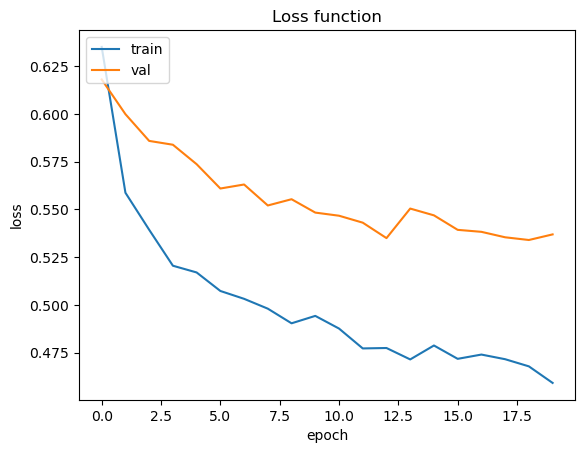

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Test

In [ ]:
x_test, y_test = test_generator[0]
for i in range(0, 5):
  print(i)
  x_temp, y_temp = test_generator[i]
  x_test, y_test = np.vstack((x_test,x_temp)), np.vstack((y_test, y_temp))
print(x_test.shape)
print(y_test.shape)

pred = model.predict(x_test)

0
1
2
3
4
(192, 224, 224, 3)
(192, 224, 224, 5)
6/6 [==============================] - 5s 822ms/step


### Dice coefficient

In [ ]:
print("Dice coefficient: \t" +  '{:.4}'.format(dice_coef(y_test, pred)))
print("Dice loss function: \t" + '{:.4}'.format(dice_loss_function(y_test, pred)))
print(dice_coef(y_test, y_test))
def dice_coef2(y, pred):
  coef = 0
  for i in range(y.shape[3]):
    intersection = np.sum(y[:,:,:,i] * pred[:,:,:,i])
    set_size = np.sum(y[:,:,:,i]) + np.sum(pred[:,:,:,i])
    coef += (2*intersection)/set_size
  return coef/5.0

print(dice_coef2(y_test, pred))
print(dice_loss_function(tf.constant(y_test), tf.constant(pred)))

Dice coefficient: 	0.5236
Dice loss function: 	0.5409
tf.Tensor(1.0, shape=(), dtype=float64)
0.45909721064586273
tf.Tensor(0.5409028744030533, shape=(), dtype=float64)


### IoU

In [ ]:
def mean_intersection_over_union(y, pred):
    result = 0
    for i in range(num_classes):
        intersection = np.sum(y[:,:,:,i]*pred[:,:,:,i])
        union = np.sum(y[:,:,:,i]) + np.sum(pred[:,:,:,i]) - intersection
        print("IoU of " + class_names[i] + " is " + '{:.4}'.format(100*intersection/union))
        result += intersection/union
    return result/num_classes
print("mean intersection over union is " + '{:.4}'.format(100*mean_intersection_over_union(y_test, pred)))

IoU of background is 49.87
IoU of rigid_plastic is 17.64
IoU of cardboard is 33.0
IoU of metal is 29.47
IoU of soft_plastic is 23.36
mean intersection over union is 30.67


### Percentage of pixels categorized correctly

In [ ]:
# Calculation of the percentage of pixels that are categorized correctly
y_pred_binary = np.argmax(pred, axis=3).flatten()
correct_predictions2 = np.sum(np.equal(y_pred_binary, np.argmax(y_test, axis=3).flatten()))
n, h, w, _ = y_test.shape
pixels = n*h*w
accuracy = correct_predictions2 / pixels * 100.0
print("acuracy is "  + '{:.4}'.format(accuracy))

acuracy is 52.36


### Confusion Matrix

In [ ]:
#See lab 4 for explanation of Confusion Matrix
pred_flat = np.array([])
image_labels_flat = np.array([])
print(pred.shape)
for i in range(pred.shape[0]):
  image_predictions = np.argmax(pred[i], axis=2).flatten()
  pred_flat = np.hstack([pred_flat,image_predictions])
  img_labels = np.argmax(y_test[i], axis=2).flatten()
  image_labels_flat = np.hstack([image_labels_flat, img_labels])


image_labels_flat = np.hstack([image_labels_flat, np.arange(5)])
pred_flat = np.hstack([pred_flat, np.arange(5)])
conf_matrix = confusion_matrix(image_labels_flat, pred_flat)
print("1: background 2: rigid_plastic 3: cardboard 4: metal 5: soft_plastic\n")
print("Confusion Matrix")
print(conf_matrix-np.eye(5, dtype=np.int64))

np.set_printoptions(precision=2)
conf_matrix_norm = ((conf_matrix.T-np.eye(5, dtype=np.int64)) / np.sum(conf_matrix, axis=1)).T
print("\nNormalized Confusion Matrix")
print(np.round(conf_matrix_norm,3)*100)

(192, 224, 224, 5)
1: background 2: rigid_plastic 3: cardboard 4: metal 5: soft_plastic

Confusion Matrix
[[2805867  122274  536573   43402  371970]
 [ 362558  319023   40266   88651  516468]
 [ 711669   31186  955220   36820  240337]
 [ 229928   61835   31622  265759   47770]
 [ 442377  266182  311213   96160  698662]]

Normalized Confusion Matrix
[[72.3  3.2 13.8  1.1  9.6]
 [27.3 24.   3.   6.7 38.9]
 [36.   1.6 48.4  1.9 12.2]
 [36.1  9.7  5.  41.7  7.5]
 [24.4 14.7 17.2  5.3 38.5]]


### Precision and Recall

In [ ]:

show_interesting_facts = False
if show_interesting_facts:
  print("------------------------------ interesting facts ----------------------------------------")
  print("percentage of pixels that are cardboard in training set: " + '{:.4}'.format(100*np.sum(conf_matrix[2,:])/np.sum(conf_matrix)))
  print("percentage of pixels that are background in training set: " + '{:.4}'.format(100*np.sum(conf_matrix[0,:])/np.sum(conf_matrix)) + " and accuracy is " + '{:.4}'.format(accuracy))
  print("Therefore the model is "  + '{:.4}'.format(accuracy - 100*np.sum(conf_matrix[0,:])/np.sum(conf_matrix)) + " percentage points better in accuracy than always guessing background")
  print("\npercentage of time the model guesses background: " + '{:.4}'.format(100*np.sum(conf_matrix[:,0])/np.sum(conf_matrix)))
  print("percentage of time the model guesses cardboard: " + '{:.4}'.format(100*np.sum(conf_matrix[:,2])/np.sum(conf_matrix)))

  print("\n----------------------------------------------------------------------------------------")
classes = ["background", "rigid plastic", "cardboard", "metal\t", "soft plastic"]
print("Precision with regards to each class:\n")
conf_matrix = conf_matrix - np.eye(5, dtype=np.int64)
for i in range(len(classes)):
  if np.sum(conf_matrix[:,i]) == 0:
    print( classes[i] + ": \t" + "no predictions")
  else:
    precision = 100*conf_matrix[i,i]/np.sum(conf_matrix[:,i])
    print( classes[i] + ": \t" + '{:.4}'.format(precision))

# This is also just the diagonal of the normalized confusion matrix
print("\nRecall with regards to each class:\n")
for i in range(len(classes)):
  if np.sum(conf_matrix[i,:]) == 0:
    print(classes[i] + ": \t" + "no predictions")
  else:
    recall = 100*conf_matrix[i,i]/np.sum(conf_matrix[i,:])
    print(classes[i] + ": \t" + '{:.4}'.format(recall))

Precision with regards to each class:

background: 	61.63
rigid plastic: 	39.85
cardboard: 	50.95
metal	: 	50.07
soft plastic: 	37.26

Recall with regards to each class:

background: 	72.31
rigid plastic: 	24.04
cardboard: 	48.36
metal	: 	41.73
soft plastic: 	38.5


### Visual inspection

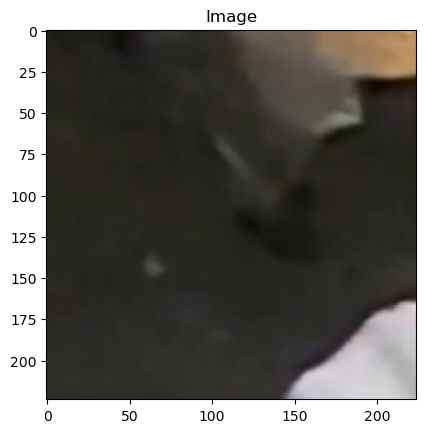

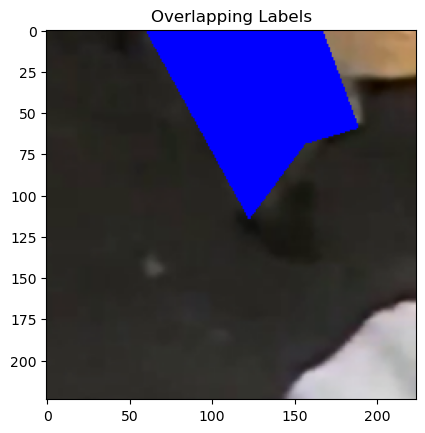

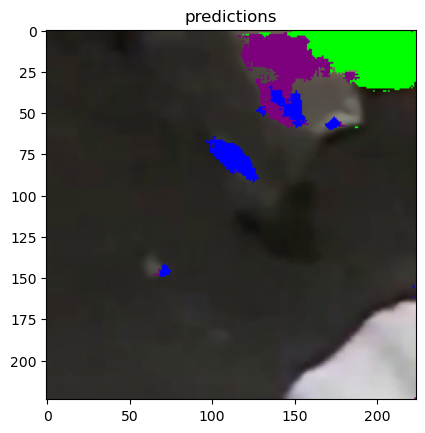

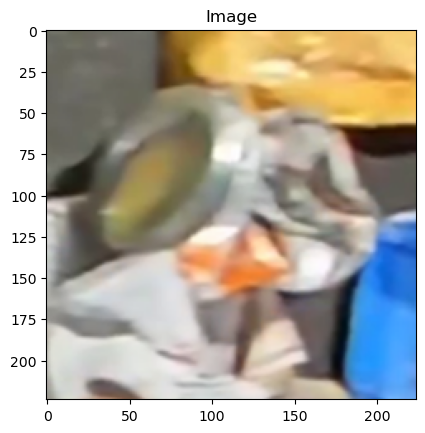

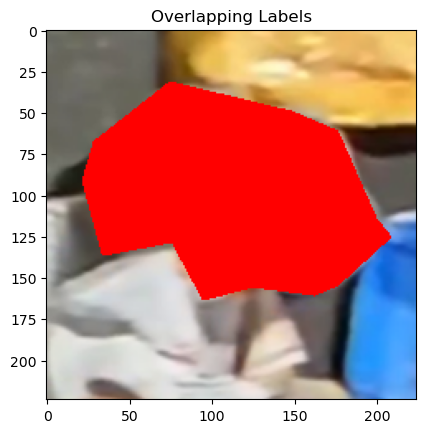

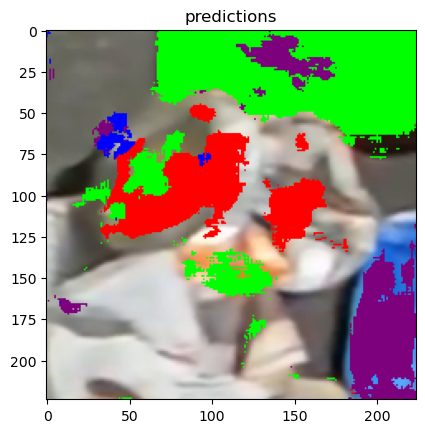

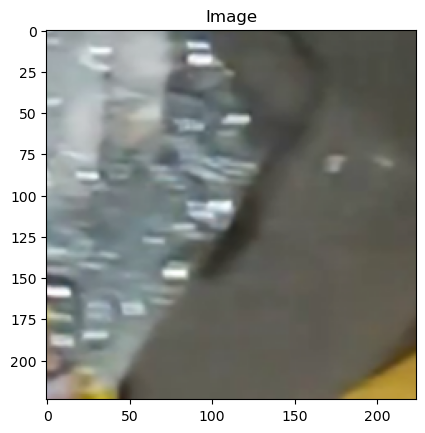

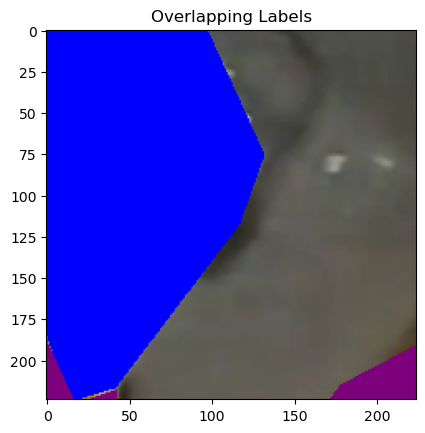

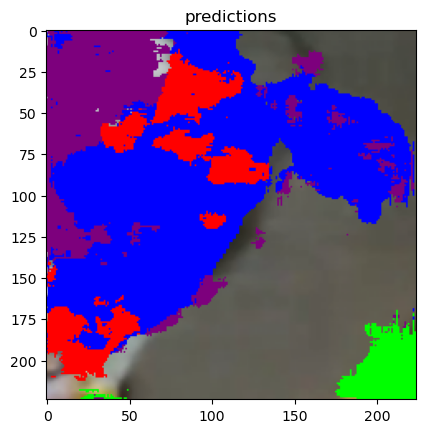

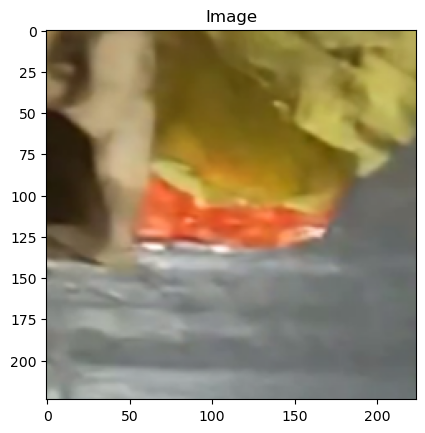

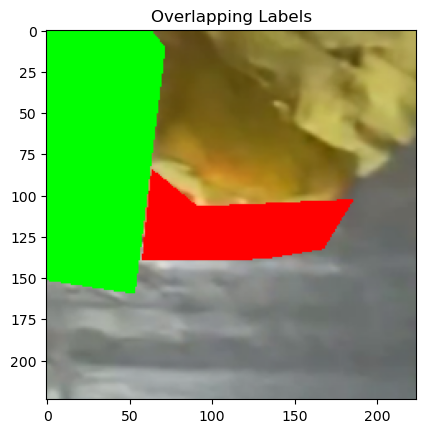

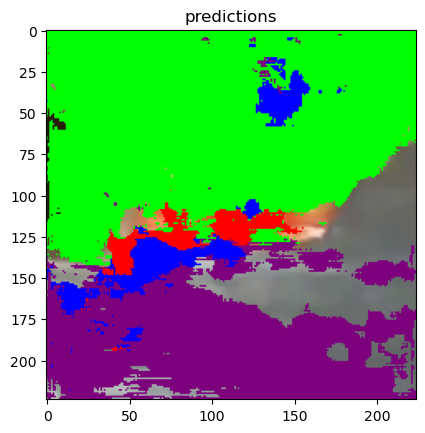

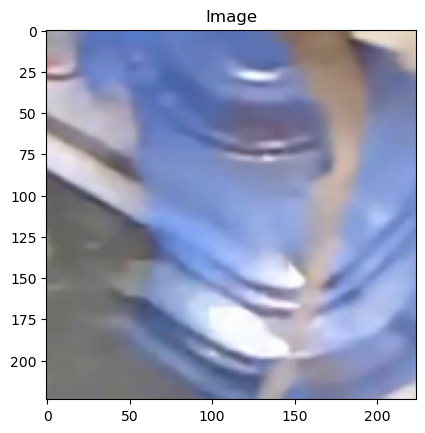

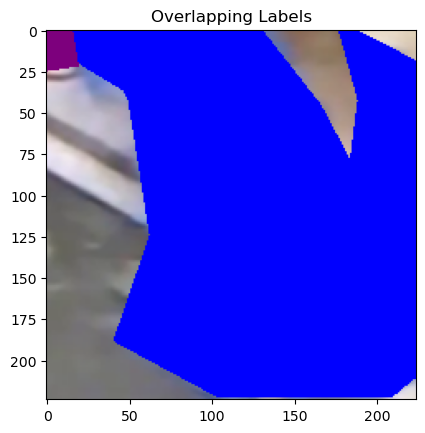

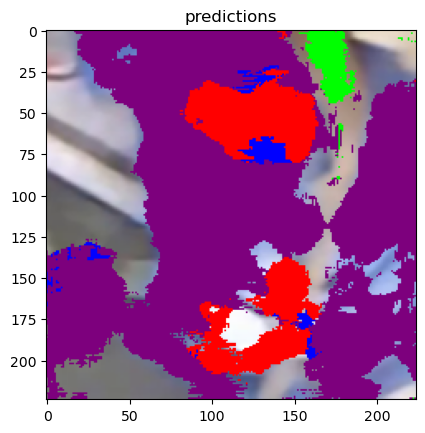

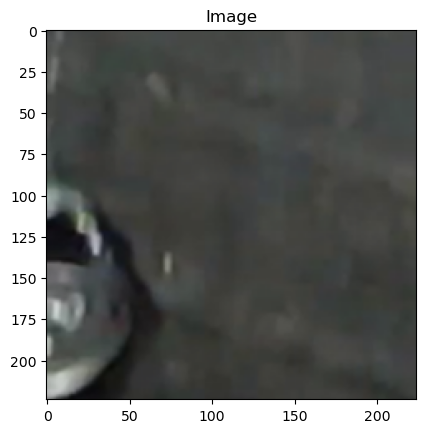

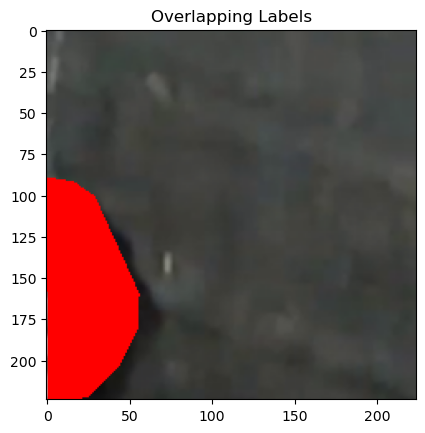

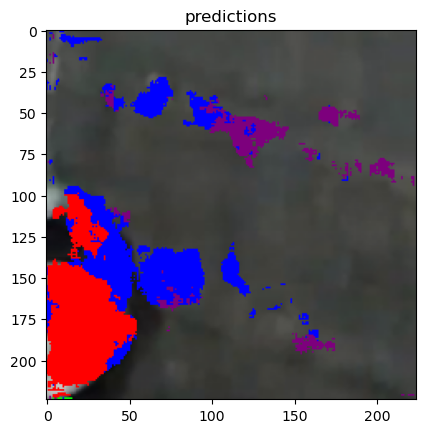

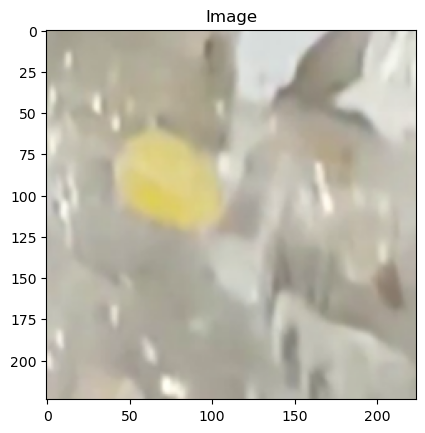

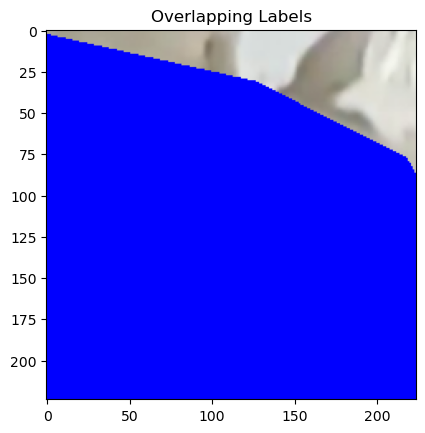

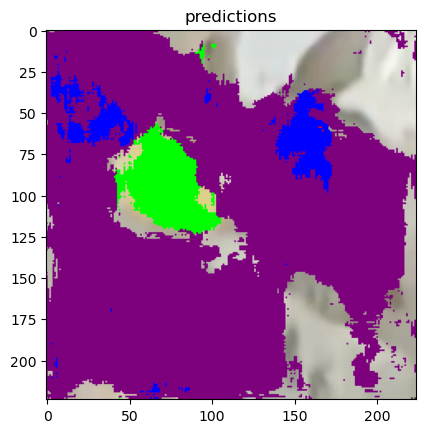

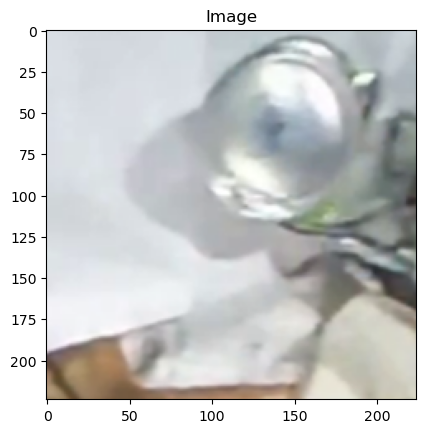

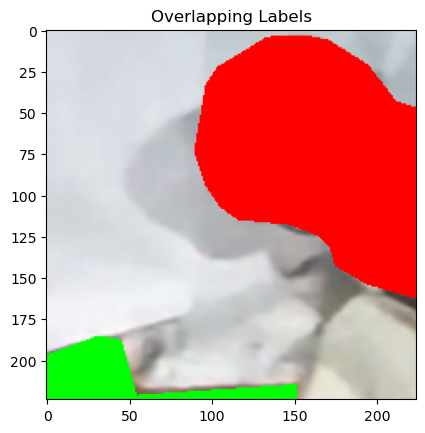

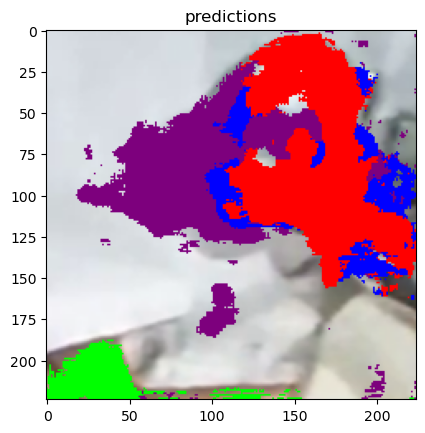

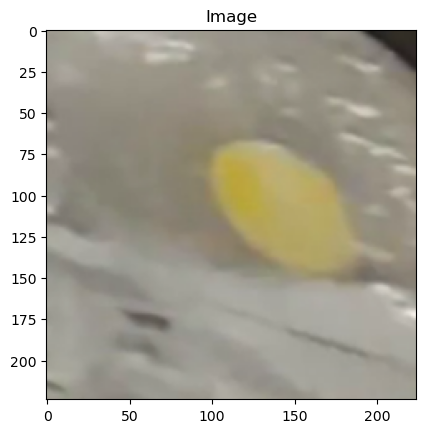

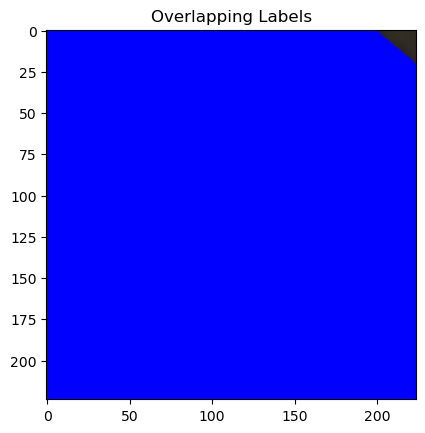

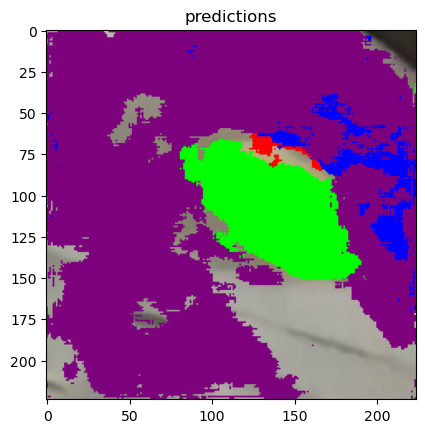

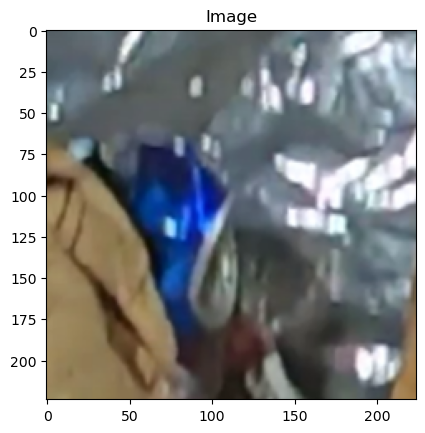

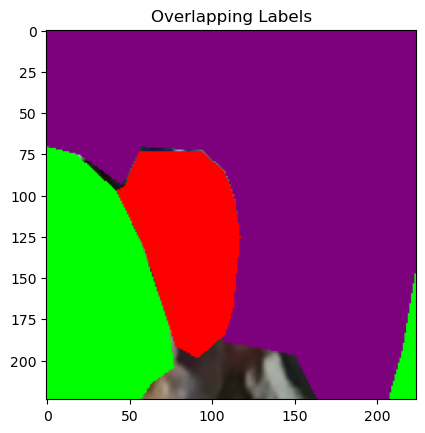

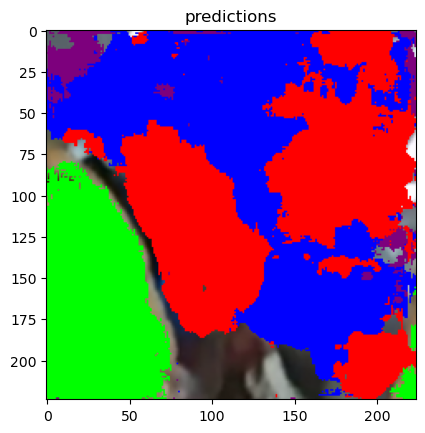

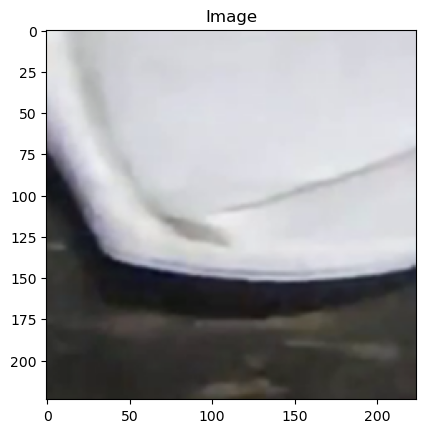

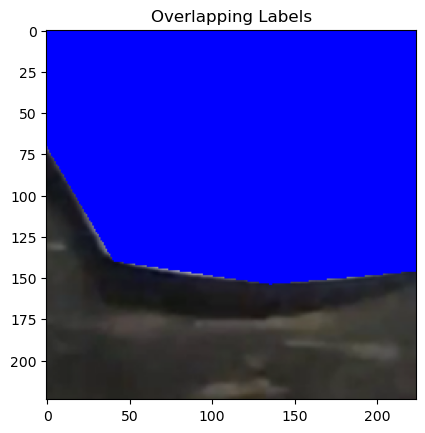

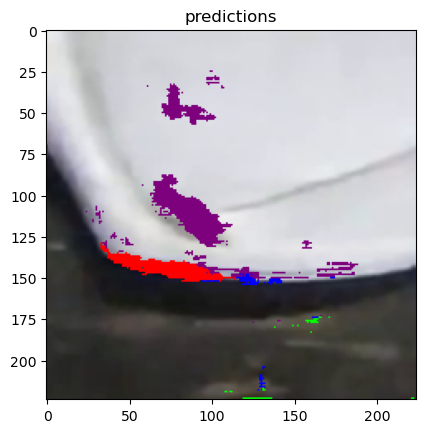

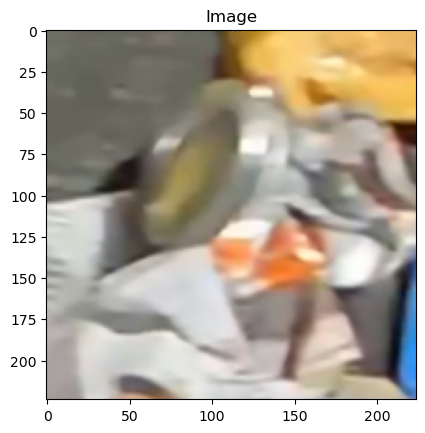

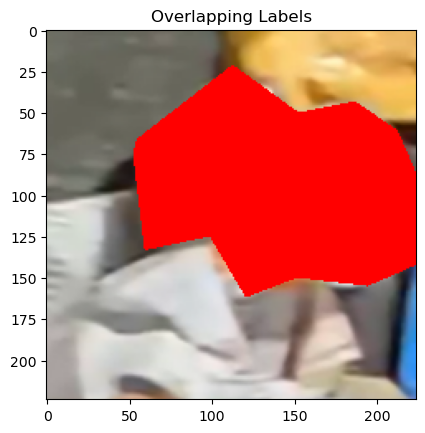

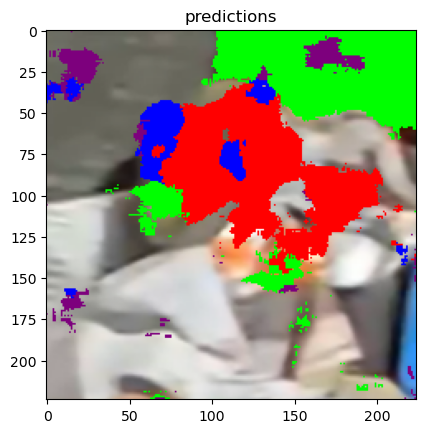

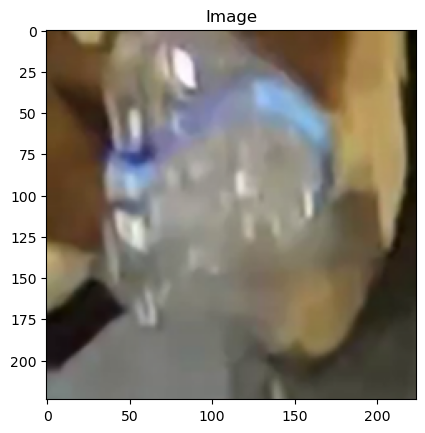

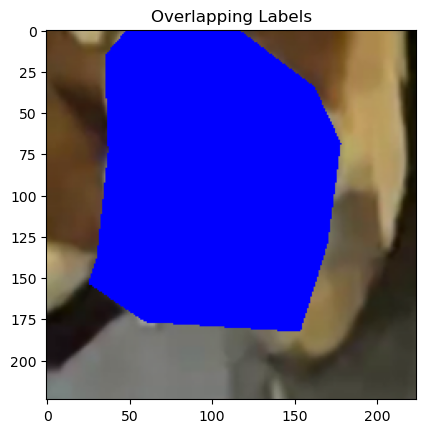

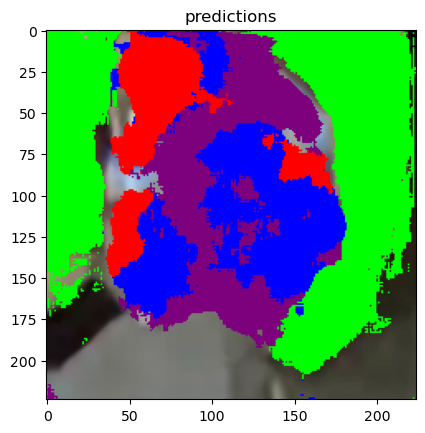

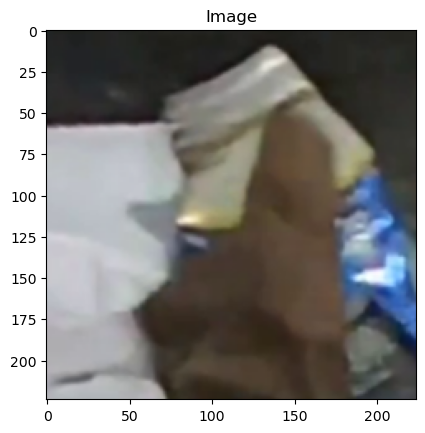

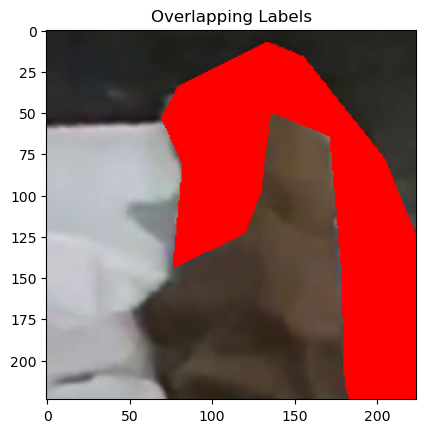

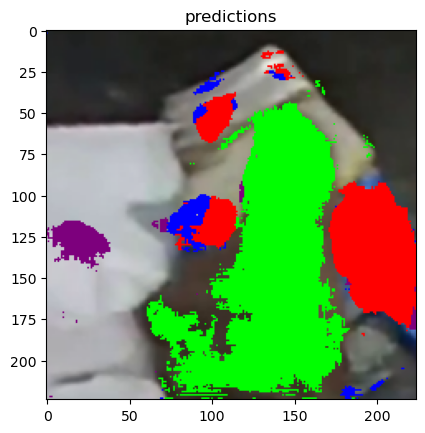

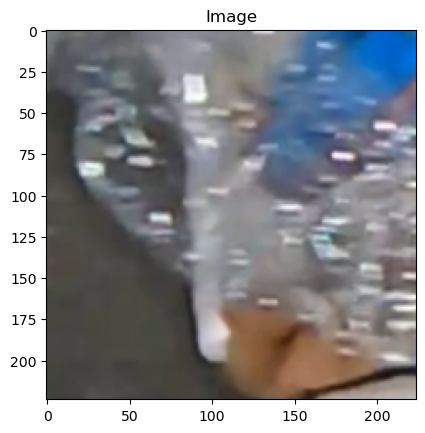

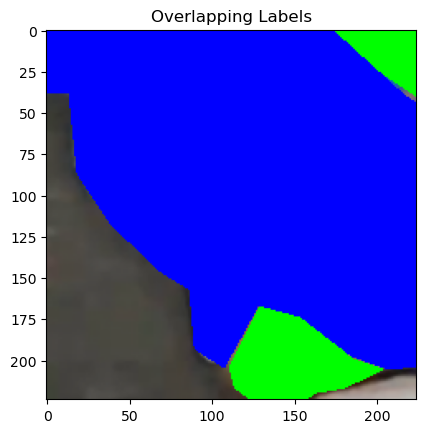

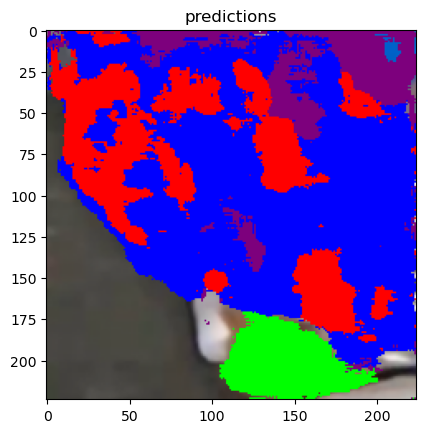

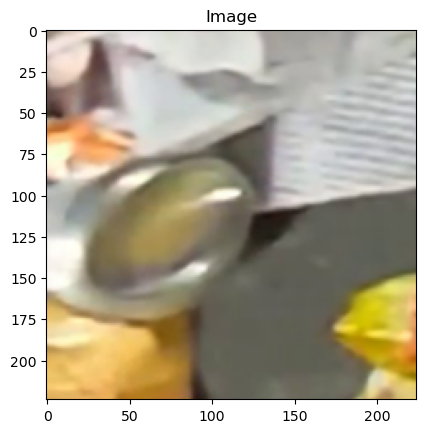

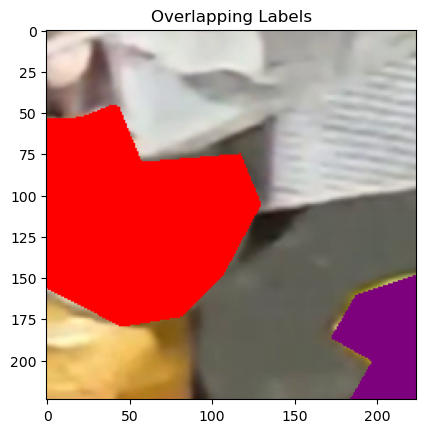

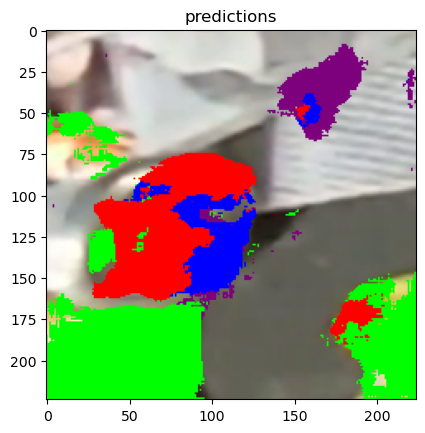

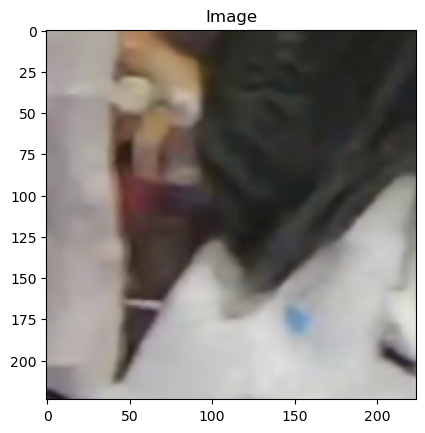

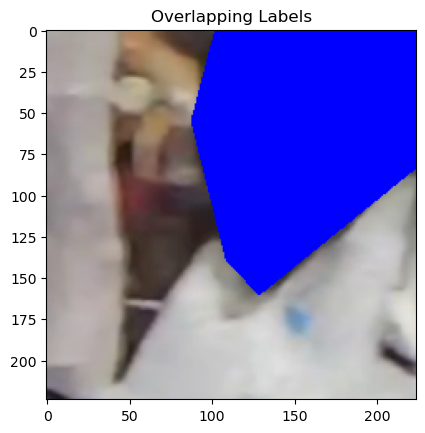

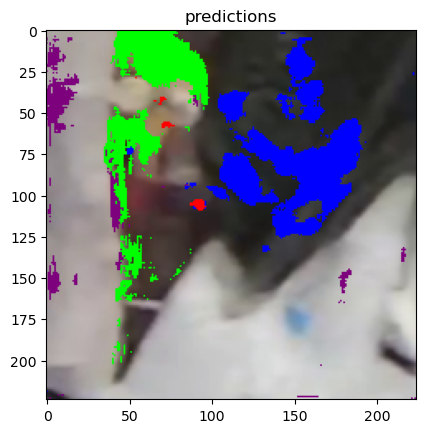

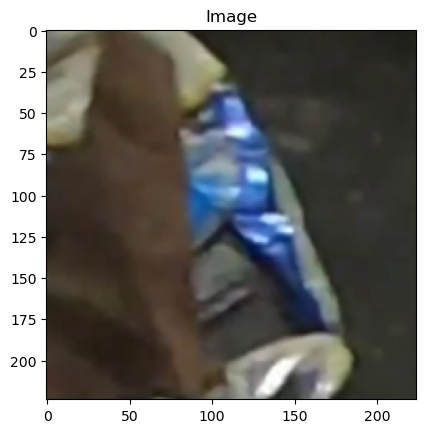

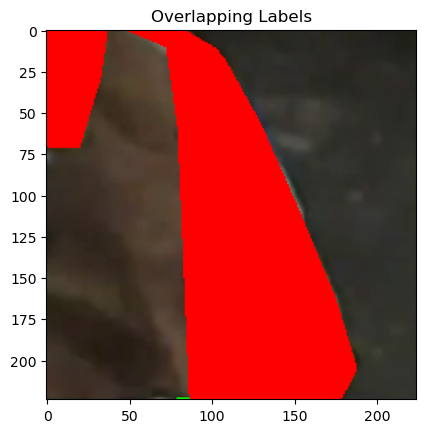

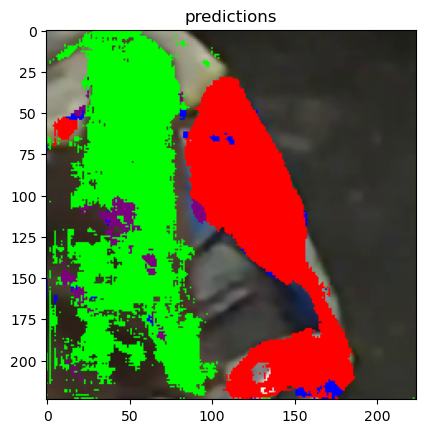

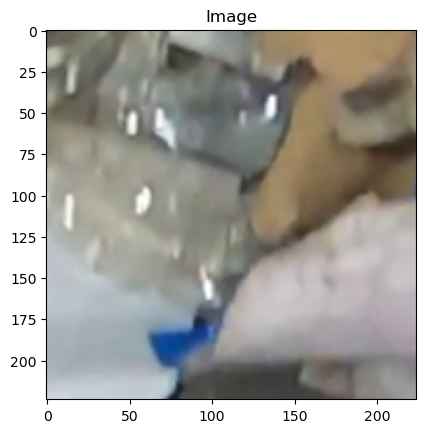

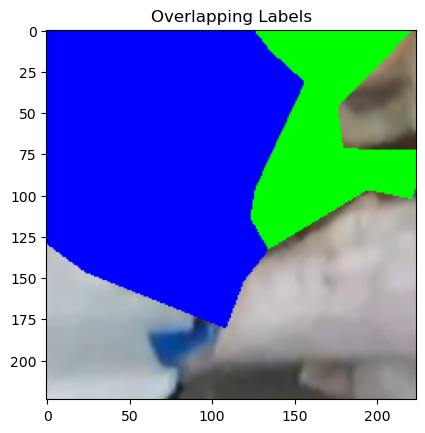

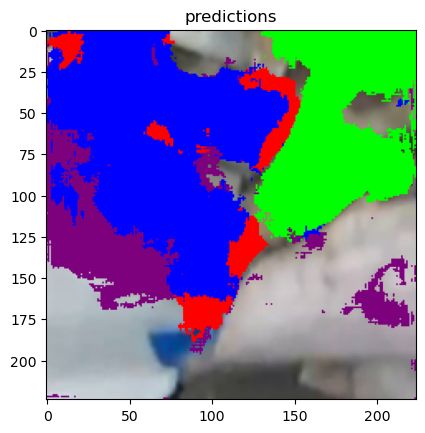

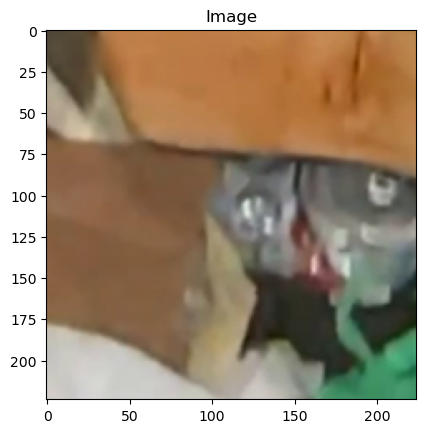

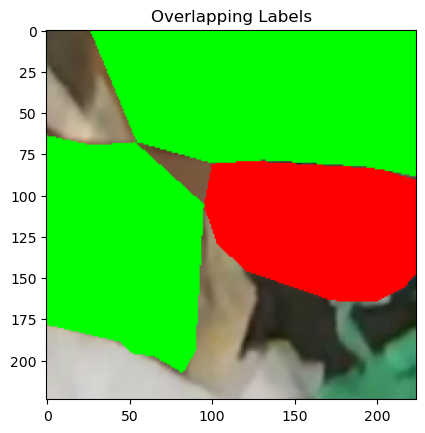

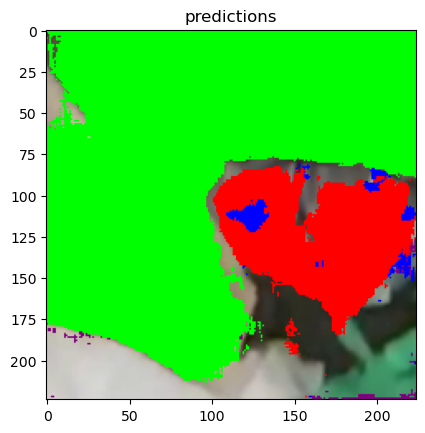

In [ ]:
for i in range(0, pred.shape[0], 10):
  Make_Overlapping_Plot2(x_test[i].astype(np.uint8), y_test[i], pred=pred[i])